# Проект: Прогнозирование оттока клиентов

## Цель работы:
Научиться предсказывать отток клиентов по имеющимся данным.   

## План работы:

### EDA
* Загрузка данных
* Просмотр распределения признаков
* Проверка типов данных
* Проверка на наличие пропусков, дубликатов
* Проверка размерности датафреймов
### Подготовка и анализ данных
* Соединение необходимых таблиц
* Кодирование категориальных признаков методом OHE
* Исследование корелляции признаков с помощью библиотеки phik
* Повторная оценка распределения признаков
* Оценка количества пропусков, устранение при необходимости
* Устранение дисбаланса признаков
* Отбор наиболее значимых признаков
### Построение и обучение моделей
* Последовательное построение моделей (Catboost, LogisticRegression, RndomForest)
* Подбор параметров для моделей
* Оценка моделей кросс-валидацией
* Выбор лучшей модели
* Анализируем важность признаков
* Проверка модели на тестовой выборке
### Вывод

Импорт необходимых библиотек

In [ ]:
RANDOM_STATE =  220523

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import phik
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from random import randint
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import datetime

plt.rcParams["figure.figsize"] = (5,5)

Подключение диска

# EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
contract = pd.read_csv('/content/drive/MyDrive/telecom/contract_new.csv')
internet = pd.read_csv('/content/drive/MyDrive/telecom/internet_new.csv')
personal = pd.read_csv('/content/drive/MyDrive/telecom/personal_new.csv')
phone = pd.read_csv('/content/drive/MyDrive/telecom/phone_new.csv')


In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Размерность данных:

In [ ]:
contract.shape

(7043, 8)

Количество пропусков:

In [ ]:
contract.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

Проверка типов данных:

In [ ]:
contract.dtypes

customerID           object
BeginDate            object
EndDate              object
Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
dtype: object

Преобразование столбца TotalCharges

In [ ]:
contract['TotalCharges'] = pd.to_numeric(contract['TotalCharges'], errors = 'coerce')

Перепроверка пропусков

In [ ]:
contract.isna().sum()

customerID           0
BeginDate            0
EndDate              0
Type                 0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
dtype: int64

Удаление объектов с пропусками

In [ ]:
contract = contract.dropna()

Проверка на явные дубликаты

In [ ]:
contract.duplicated().sum()

0

Процент ушедших клиентов:

In [ ]:
are_gone = contract[contract['EndDate'] != 'No']
are_gone['customerID'].count()/contract['customerID'].count()

0.15656996587030717

Распределение типов оплаты среди ушедших клиентов:

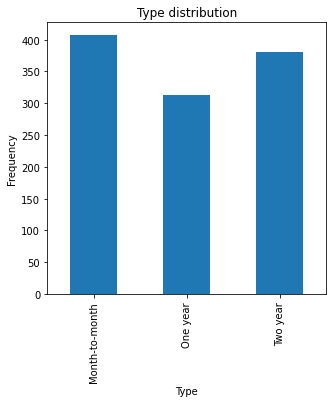

In [ ]:
are_gone.groupby('Type').count()['customerID'].plot(kind = 'bar', ylabel = 'Frequency', xlabel = 'Type', title = 'Type distribution')
plt.show()

Распределение типов оплаты среди всех клиентов:

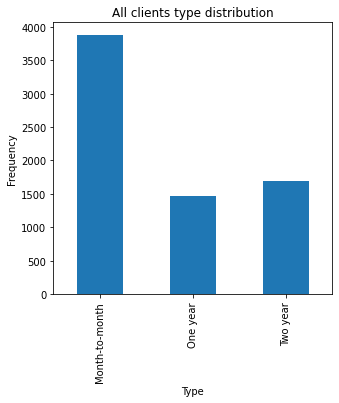

In [ ]:
contract.groupby('Type').count()['customerID'].plot(kind = 'bar', title = 'All clients type distribution', xlabel = 'Type',ylabel = 'Frequency')
plt.show()

Распределение признака TotalCharges для ушедших клиентов:

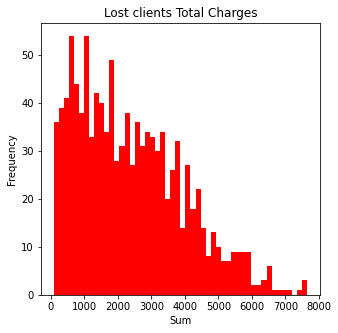

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(are_gone['TotalCharges'], bins = 50, color = 'r')

ax.set_title('Lost clients Total Charges')

ax.set_xlabel('Sum')
ax.set_ylabel('Frequency')
plt.show()

Распределение признака TotalCharges для общего количества клиентов:

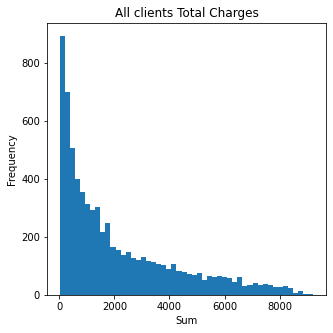

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(contract['TotalCharges'], bins = 50)

ax.set_title('All clients Total Charges')

ax.set_xlabel('Sum')
ax.set_ylabel('Frequency')
plt.show()

Распределение признака MonthlyCharges для ушедших клиентов:

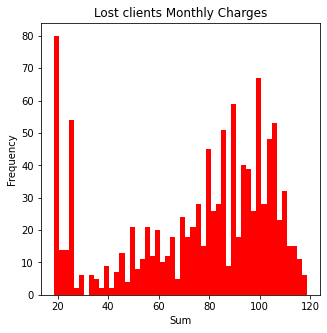

In [ ]:

fig, ax = plt.subplots(1, 1)
ax.hist(are_gone['MonthlyCharges'], bins = 50, color = 'r')

ax.set_title('Lost clients Monthly Charges')

ax.set_xlabel('Sum')
ax.set_ylabel('Frequency')
plt.show()

Распределение признака TotalCharges для общего количества клиентов:

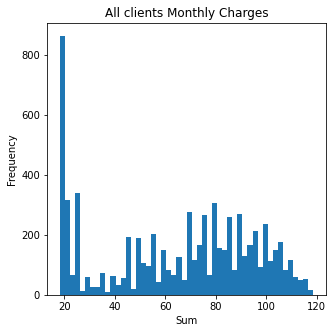

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(contract['MonthlyCharges'], bins = 50)

ax.set_title("All clients Monthly Charges")

ax.set_xlabel('Sum')
ax.set_ylabel('Frequency')
plt.show()

In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Размерность датафрема internet

In [ ]:
internet.shape

(5517, 8)

Проверка на пропуски

In [ ]:
internet.isna().sum()

customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

Проверка на дубликаты

In [ ]:
internet.duplicated().sum()

0

In [ ]:
internet.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [ ]:
cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

Распределения данных в датафрейме internet:

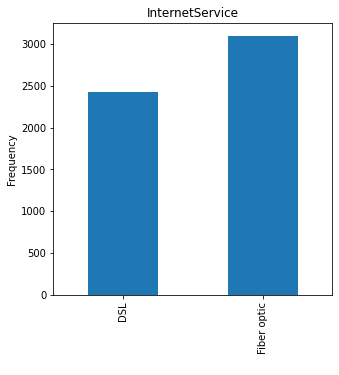

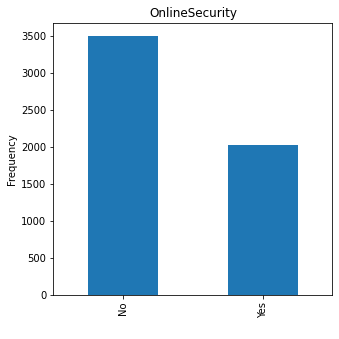

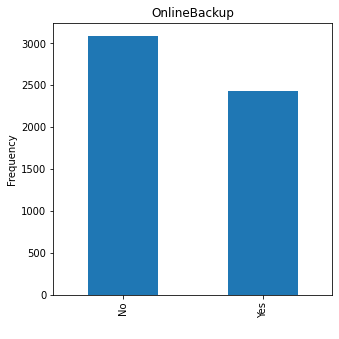

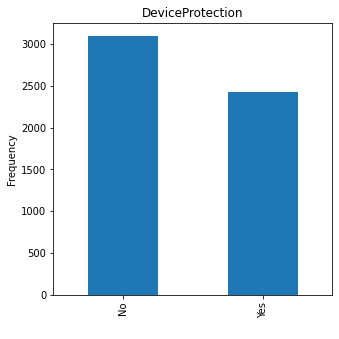

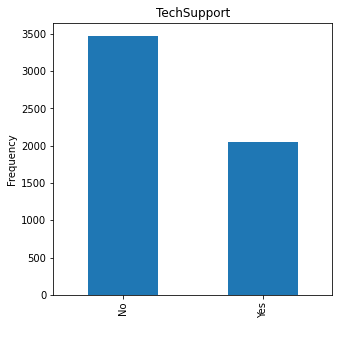

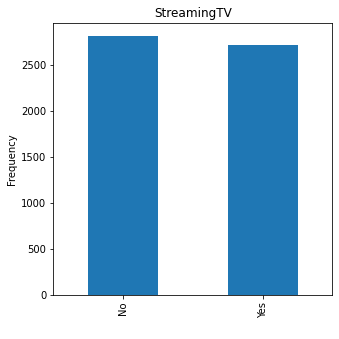

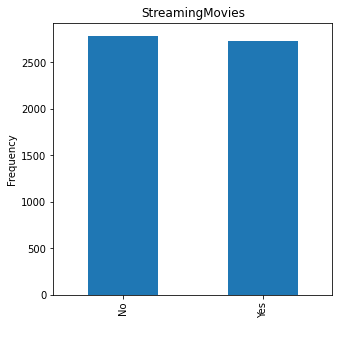

In [ ]:
for i in cols:
    internet.groupby(i).count()['customerID'].plot(kind = 'bar', ylabel = 'Frequency', xlabel = ' ', title = i)
    plt.show()

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
personal.isna().sum()

customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

In [ ]:
personal.shape

(7043, 5)


Распределение пользователей мужского и жеского полов:

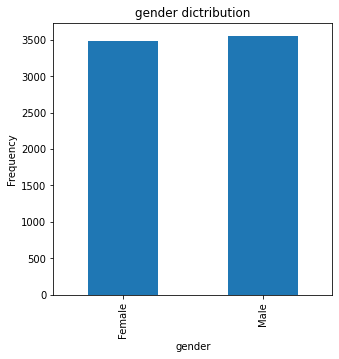

In [ ]:
personal.groupby('gender').count()['customerID'].plot(kind = 'bar', title = 'gender dictribution', ylabel = 'Frequency', xlabel = 'gender')
plt.show()

In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
phone.isna().sum()

customerID       0
MultipleLines    0
dtype: int64

In [ ]:
phone.shape

(6361, 2)

Распределенеи признака MultipleLines

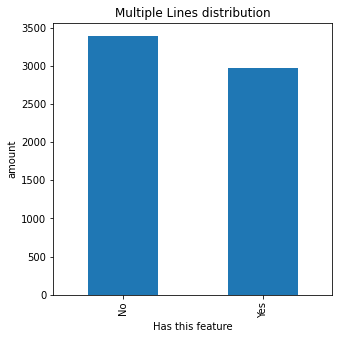

In [ ]:
phone.groupby('MultipleLines')['customerID'].count().plot(kind ='bar',title = 'Multiple Lines distribution', xlabel = 'Has this feature', ylabel = 'amount')
plt.show()

### Вывод:

В результате анализа были предварительно осмотрены данные всех таблиц: оценен дисбаланс классов, проверено наличие явных дубликатов, удалены объекты с пропущенными значениями, и построены графики распределения признаков каждой таблицы.

# Подготовка и анализ данных

In [ ]:
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.60
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.50


In [ ]:
internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [ ]:
internet.shape

(5517, 8)

In [ ]:
personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [ ]:
phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [ ]:
df = contract.merge(internet, on = 'customerID', how = 'outer')
df.isna().sum()

customerID             0
BeginDate              5
EndDate                5
Type                   5
PaperlessBilling       5
PaymentMethod          5
MonthlyCharges         5
TotalCharges           5
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
dtype: int64

In [ ]:
df = df.merge(phone, on = 'customerID', how = 'outer')

In [ ]:
df.isna().sum()

customerID             0
BeginDate             11
EndDate               11
Type                  11
PaperlessBilling      11
PaymentMethod         11
MonthlyCharges        11
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

In [ ]:
df = df.merge(personal, on = 'customerID', how = 'outer')

In [ ]:
df.isna().sum()

customerID             0
BeginDate             11
EndDate               11
Type                  11
PaperlessBilling      11
PaymentMethod         11
MonthlyCharges        11
TotalCharges          11
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
dtype: int64

После соединения таблиц видно, что примерно 1.5К клиентов не пользуются интернет-услугами компании, и еще 680 не пользуются возможностью ведения параллельных линий во время звонка. Такие пропуски можно заполнить значениями "No". Так же в итоговом датасете наблюдаются 11 объектов, большая часть информации о которых неизвестна, их можно удалить.

In [ ]:
columns = np.append(np.array(internet.columns[1:]),'MultipleLines')

for i in columns:
    df.loc[df[i].isna() == True, i] = 'No'

In [ ]:
df = df.dropna()

In [ ]:
df.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
dtype: int64

Создадим целевой признак

In [ ]:
pd.to_datetime('2020-05-01', format='%Y-%m-%d').date()

datetime.date(2020, 5, 1)

Создадим признак, содержащий количество дней длительности контракта

In [ ]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df.loc[df['EndDate'] == 'No','EndDate'] = pd.to_datetime('2020-02-01', format='%Y-%m-%d').date()
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d')

In [ ]:
df['Days'] = df['EndDate'] - df['BeginDate']

In [ ]:
df['Days'] = df['Days'].dt.days

Создадим целевой признак

In [ ]:
df['HasLeft'] = (df['EndDate'] != pd.to_datetime('2020-02-01', format='%Y-%m-%d')).astype(int)

In [ ]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,Days,HasLeft
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,...,No,No,No,No,Female,0,Yes,No,31,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,2071.84,DSL,Yes,...,No,No,No,No,Male,0,No,No,1036,0
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,...,No,No,No,No,Male,0,No,No,123,0
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,1371,0
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,...,No,No,No,No,Female,0,No,No,153,0


In [ ]:
df.shape

(7032, 22)

Удалим неинформативные признаки:
1. CustomId - после соединения в нем нет нужды
2. BeginDate и EndDate - целевой признак создан,а дата начала пользования услугами не имеет значения

In [ ]:
df = df.drop(['customerID', 'BeginDate', 'EndDate'], axis = 1)

### Графики распределения признаков

In [ ]:
df.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,gender,SeniorCitizen,Partner,Dependents,Days,HasLeft
0,Month-to-month,Yes,Electronic check,29.85,31.04,DSL,No,Yes,No,No,No,No,No,Female,0,Yes,No,31,0
1,One year,No,Mailed check,56.95,2071.84,DSL,Yes,No,Yes,No,No,No,No,Male,0,No,No,1036,0
2,Month-to-month,Yes,Mailed check,53.85,226.17,DSL,Yes,Yes,No,No,No,No,No,Male,0,No,No,123,0
3,One year,No,Bank transfer (automatic),42.30,1960.60,DSL,Yes,No,Yes,Yes,No,No,No,Male,0,No,No,1371,0
4,Month-to-month,Yes,Electronic check,70.70,353.50,Fiber optic,No,No,No,No,No,No,No,Female,0,No,No,153,0


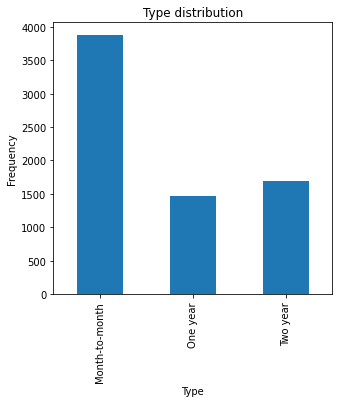

In [ ]:
df.groupby('Type').count()['PaperlessBilling'].plot(kind = 'bar', ylabel = 'Frequency', xlabel = 'Type', title = 'Type distribution')
plt.show()

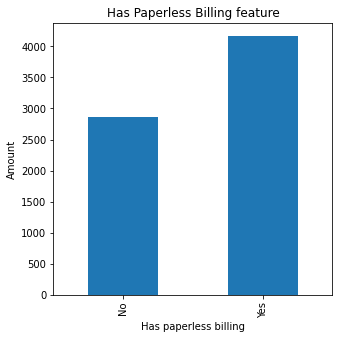

In [ ]:
df.groupby('PaperlessBilling').count()['Type'].plot(kind = 'bar', ylabel = 'Amount', xlabel = 'Has paperless billing', title = 'Has Paperless Billing feature')
plt.show()

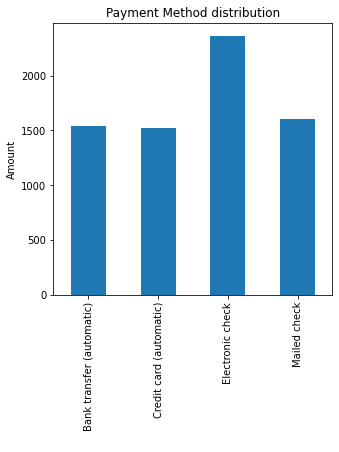

In [ ]:
df.groupby('PaymentMethod').count()['Type'].plot(kind = 'bar', ylabel = 'Amount', xlabel = ' ', title = 'Payment Method distribution')
plt.show()

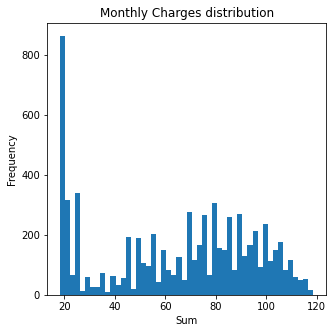

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(df['MonthlyCharges'], bins = 50)

ax.set_title('Monthly Charges distribution')

ax.set_xlabel('Sum')
ax.set_ylabel('Frequency')
plt.show()

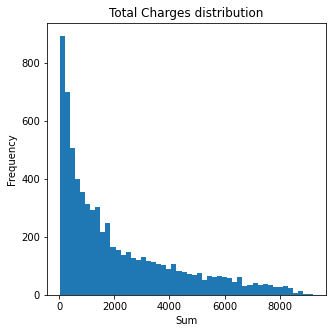

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(df['TotalCharges'], bins = 50)

ax.set_title('Total Charges distribution')

ax.set_xlabel('Sum')
ax.set_ylabel('Frequency')
plt.show()

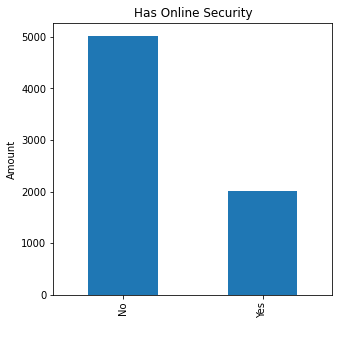

In [ ]:
df.groupby('OnlineSecurity').count()['Type'].plot(kind = 'bar', ylabel = 'Amount', xlabel = ' ', title = 'Has Online Security')
plt.show()

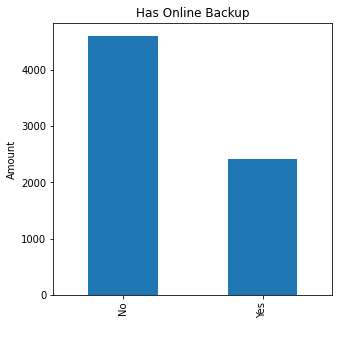

In [ ]:
df.groupby('OnlineBackup').count()['Type'].plot(kind = 'bar', ylabel = 'Amount', xlabel = ' ', title = 'Has Online Backup')
plt.show()

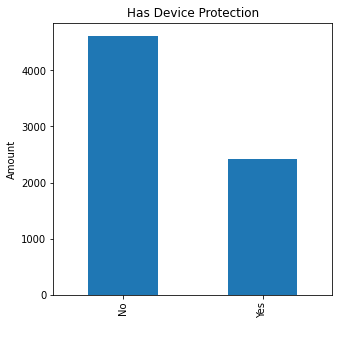

In [ ]:
df.groupby('DeviceProtection').count()['Type'].plot(kind = 'bar', ylabel = 'Amount', xlabel = ' ', title = 'Has Device Protection')
plt.show()

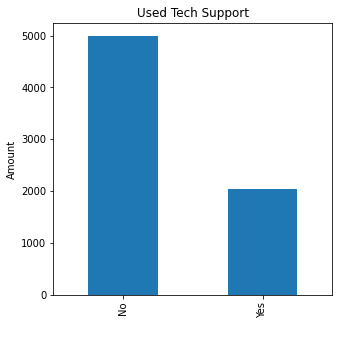

In [ ]:
df.groupby('TechSupport').count()['Type'].plot(kind = 'bar', ylabel = 'Amount', xlabel = ' ', title = 'Used Tech Support')
plt.show()

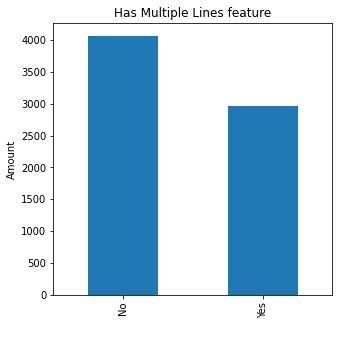

In [ ]:
df.groupby('MultipleLines').count()['Type'].plot(kind = 'bar', ylabel = 'Amount', xlabel = ' ', title = 'Has Multiple Lines feature')
plt.show()

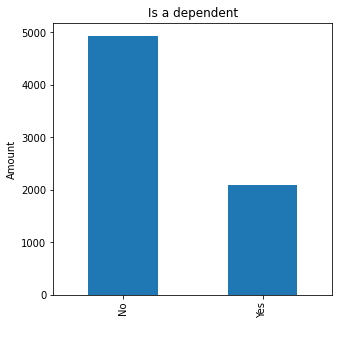

In [ ]:
df.groupby('Dependents').count()['Type'].plot(kind = 'bar', ylabel = 'Amount', xlabel = ' ', title = 'Is a dependent')
plt.show()

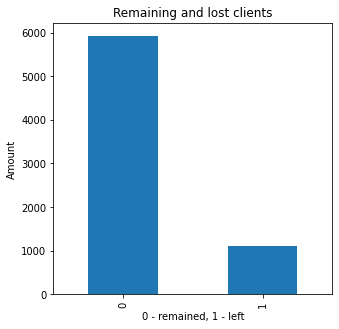

In [ ]:
df.groupby('HasLeft').count()['Type'].plot(kind = 'bar', ylabel = 'Amount', xlabel = '0 - remained, 1 - left',title = 'Remaining and lost clients')
plt.show()

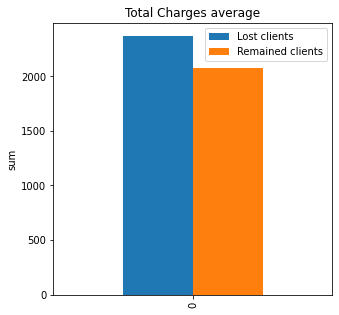

[[2371.3772752043596], [2071.701613555893]]

In [ ]:
arr = [[df[df['HasLeft'] == 1]['TotalCharges'].mean()], [df[df['HasLeft'] == 0]['TotalCharges'].mean()]]
data = pd.DataFrame({'Lost clients':arr[0], 'Remained clients':arr[1]})
data.plot(kind = 'bar', title = 'Total Charges average', ylabel = 'sum')
plt.show()
arr

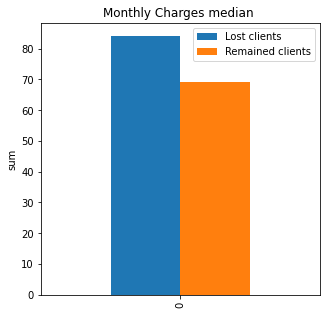

[[84.2], [69.25]]

In [ ]:
arr = [[df[df['HasLeft'] == 1]['MonthlyCharges'].median()], [df[df['HasLeft'] == 0]['MonthlyCharges'].median()]]
data = pd.DataFrame({'Lost clients':arr[0], 'Remained clients':arr[1]})
data.plot(kind = 'bar', title = 'Monthly Charges median ', ylabel = 'sum')
plt.show()
arr

Вывод: Построены графики распределения непрерывных и категориальных признаков финальной таблицы. Наглядно виден дисбаланс классов: отношение клиентов, которые решлили выбрать другого оператора связи, к лояльным примерно 1/6. Так же вычисленны медианные значения месячной прибыли с клиентов - она составила 84.2 у ушедших клиентов и 69.25 у оставшихся, и средняя суммарная прибыль -  2371.3 у ушедших клиентов и 2071 у оставшихся.

### Анализ корелляции признаков

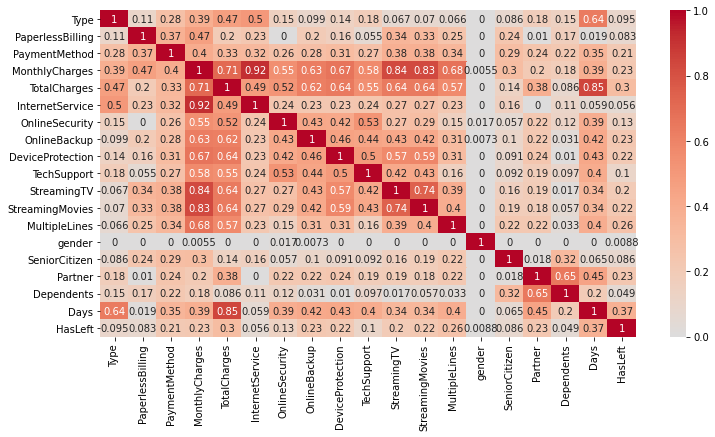

In [ ]:
plt.figure(figsize = (12, 6))
sns.heatmap(df.phik_matrix(interval_cols = ['MonthlyCharges', 'TotalCharges','Days']), annot = True, cmap = 'coolwarm', center=0)
plt.show()

Выберем и удалим признаки с мультиколлинеарностью

In [ ]:
copy = df.copy()

In [ ]:
df = copy.drop([
    'gender',
    'InternetService',
    'StreamingMovies',
    'PaperlessBilling',
    'OnlineSecurity',
    'StreamingTV',
    'TotalCharges'
    ], axis = 1)

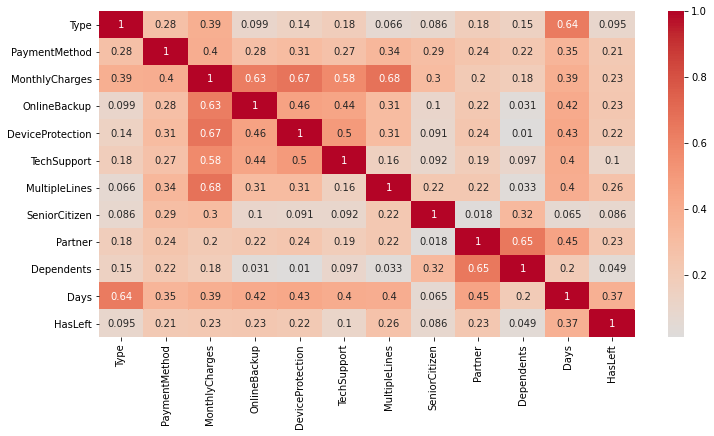

In [ ]:
plt.figure(figsize = (12, 6))
sns.heatmap(df.phik_matrix(interval_cols = ['MonthlyCharges', 'TotalCharges', 'Days']), annot = True, cmap = 'coolwarm', center=0)
plt.show()

## Кодирование признаков

Найдем категориальные признаки

In [ ]:
obj_features = df.select_dtypes(include = 'object').columns.to_list()

Деление выборки на тестовую и тренировочную:

In [ ]:
train, test = train_test_split(df, test_size = 0.25, random_state = RANDOM_STATE)

In [ ]:
X_train = train.drop('HasLeft', axis = 1)
Y_train = train['HasLeft']
X_test = test.drop('HasLeft', axis = 1)
Y_test = test['HasLeft']

In [ ]:
df.head()

,Type,PaymentMethod,MonthlyCharges,OnlineBackup,DeviceProtection,TechSupport,MultipleLines,SeniorCitizen,Partner,Dependents,Days,HasLeft
0,Month-to-month,Electronic check,29.85,Yes,No,No,No,0,Yes,No,31,0
1,One year,Mailed check,56.95,No,Yes,No,No,0,No,No,1036,0
2,Month-to-month,Mailed check,53.85,Yes,No,No,No,0,No,No,123,0
3,One year,Bank transfer (automatic),42.30,No,Yes,Yes,No,0,No,No,1371,0
4,Month-to-month,Electronic check,70.70,No,No,No,No,0,No,No,153,0


### Кодирование методом One Hot

In [ ]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [ ]:
encoder_ohe.fit(X_train[obj_features])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [ ]:
X_train_ohe = X_train.copy()
X_train_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_train_ohe[obj_features])
X_train_ohe = X_train_ohe.drop(obj_features, axis = 1)

X_test_ohe = X_test.copy()
X_test_ohe[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(X_test_ohe[obj_features])
X_test_ohe = X_test_ohe.drop(obj_features, axis = 1)

In [ ]:
X_train_ohe

,MonthlyCharges,SeniorCitizen,Days,Type_One year,Type_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,MultipleLines_Yes,Partner_Yes,Dependents_Yes
3369,19.90,0,2163,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
656,78.80,0,1371,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
5074,19.80,0,641,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
3315,59.10,1,549,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1468,98.75,0,822,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,19.75,0,303,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
6870,35.15,0,975,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
338,94.80,0,1095,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
440,112.95,0,488,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0


### Кодирование методом Ordinal

In [ ]:
encoder_oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = 10)

In [ ]:
encoder_oe.fit(X_train[obj_features])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=10)

In [ ]:
X_train_oe = X_train.drop(obj_features, axis = 1)
X_train_oe[obj_features] = encoder_oe.transform(X_train[obj_features])

X_test_oe = X_test.drop(obj_features, axis = 1)
X_test_oe[obj_features] = encoder_oe.transform(X_test[obj_features])

### Стандартизация численных признаков

In [ ]:
scaler = StandardScaler()
num_features = ['MonthlyCharges','Days']
X_train_oe[num_features] = scaler.fit_transform(X_train_oe[num_features])
X_train_ohe[num_features] = scaler.fit_transform(X_train_ohe[num_features])

X_test_oe[num_features] = scaler.transform(X_test_oe[num_features])
X_test_ohe[num_features] = scaler.transform(X_test_ohe[num_features])

Данные обработаны и готовы для загрузки в модели

# Обучение моделей

## Catboost

In [ ]:
Y_train.unique()

array([0, 1])

In [ ]:
est = CatBoostClassifier(random_state = RANDOM_STATE)
rf_p_dis = {'depth':[1,3,7,10],
          'iterations':range(100,150,10),
          'learning_rate':np.arange(0.1,1,0.2),
          'l2_leaf_reg':[3,1,5,10]}
rdmsearch_1 = RandomizedSearchCV(estimator = est, param_distributions = rf_p_dis, n_iter=50, cv=5, scoring = 'roc_auc')
rdmsearch_1.fit(X_train_oe, Y_train)
model_1 = rdmsearch_1.best_estimator_

0:	learn: 0.4456469	total: 47.1ms	remaining: 6.55s
1:	learn: 0.3906232	total: 47.8ms	remaining: 3.3s
2:	learn: 0.3601723	total: 48.4ms	remaining: 2.21s
3:	learn: 0.3442408	total: 48.9ms	remaining: 1.66s
4:	learn: 0.3368997	total: 49.5ms	remaining: 1.34s
5:	learn: 0.3329415	total: 50.1ms	remaining: 1.12s
6:	learn: 0.3280936	total: 50.6ms	remaining: 961ms
7:	learn: 0.3250490	total: 51.1ms	remaining: 844ms
8:	learn: 0.3240790	total: 51.6ms	remaining: 752ms
9:	learn: 0.3222526	total: 52.2ms	remaining: 679ms
10:	learn: 0.3198985	total: 52.8ms	remaining: 619ms
11:	learn: 0.3179105	total: 53.3ms	remaining: 568ms
12:	learn: 0.3155208	total: 53.8ms	remaining: 526ms
13:	learn: 0.3150496	total: 54.3ms	remaining: 489ms
14:	learn: 0.3135864	total: 54.8ms	remaining: 457ms
15:	learn: 0.3112471	total: 55.3ms	remaining: 429ms
16:	learn: 0.3098380	total: 55.9ms	remaining: 404ms
17:	learn: 0.3082811	total: 56.4ms	remaining: 382ms
18:	learn: 0.3075846	total: 57ms	remaining: 363ms
19:	learn: 0.3040280	tota

ROC-AUC на кросс-валидации:

In [ ]:
model_1_score = rdmsearch_1.best_score_
print(model_1_score)

0.9112152858065882


## Random Forest

In [ ]:
est = RandomForestClassifier(n_jobs=-1,random_state = RANDOM_STATE)
rf_p_dist={'max_depth':[2,3,5,6,None],
            'n_estimators':[10,50,100,200,300,400,500],
            'criterion':['gini','entropy', 'log_loss'],
            'bootstrap':[True,False] }
rdmsearch = RandomizedSearchCV(est, param_distributions=rf_p_dist,
                                  n_jobs=-1, n_iter=5, cv=9)
rdmsearch.fit(X_train_oe,Y_train)
model_2 = rdmsearch.best_estimator_

ROC-AUC на кросс-валидации:

In [ ]:
model_2_score = rdmsearch.best_score_
print(model_2_score)

0.8562760712931362


## Logistic Regression

In [ ]:
est = LogisticRegression(random_state = RANDOM_STATE)
parameters = {"C":np.logspace(-3,3,7),
              "penalty":["l2"],
              "solver":['liblinear','newton-cg'],
              'class_weight':[{ 0:0.95, 1:0.05 }, { 0:0.55, 1:0.45 }, { 0:0.45, 1:0.55 },{ 0:0.05, 1:0.95 }]}



grid_search = GridSearchCV(estimator = est,
                           param_grid = parameters,
                           scoring = 'roc_auc',
                           cv = 5,
                           verbose=0)


model_3 = grid_search.fit(X_train_ohe, Y_train)

ROC-AUC на кросс-валидации:

In [ ]:
model_3_score = model_3.best_score_
print(model_3_score)

0.7444513885577665


После подбора гиперпараметров и проверки моделей на кросс-валидации лучший результат показал CatBoost. Проверим его на тестовой выборке

In [ ]:
pred = model_1.predict_proba(X_test_oe)
pred_1 = model_1.predict(X_test_oe)
print('AUC_ROC:',roc_auc_score(Y_test, pred[:,1]))
print('accuracy:',accuracy_score(Y_test,pred_1))

AUC_ROC: 0.9204510244732029
accuracy: 0.928896473265074


Результат: ROC-AUC = 0.920, accuracy = 0.928

## Оценка важности признаков

In [ ]:
imp = pd.DataFrame({'feature_importance': model_1.get_feature_importance(),
              'feature_names': X_train_oe.columns}).sort_values(by=['feature_importance'],
                                                           ascending=False)
imp

,feature_importance,feature_names
2,61.710944,Days
0,14.329458,MonthlyCharges
3,8.471615,Type
9,2.947290,Partner
8,2.908972,MultipleLines
5,2.712218,OnlineBackup
4,2.554678,PaymentMethod
6,1.785097,DeviceProtection
1,1.109967,SeniorCitizen
10,1.013924,Dependents


По данным таблицы, три наиболее важных признака - Days, MonthlyCharges и Type. Наименее важный - Tech Support

## Вывод

Целью работы была научитьс япредсказывать отток клиентов компании. В ходе работы, из предоставленных датасетов была скопанована одна таблица, из которой были отобраны наиболее значимые признаки для обчения моделей. Данные таблицы были обработаны: заполнены пропуски, удалены лишние столбцы, созданы необходимые признаки; закодированы, была оценена корелляция признаков через матрицу корелляций. По новой таблице построены графики распределений каждого признака. Готовый датасет использовался для обучения трех моделей: CatBoostClassifier, RandomForest и LogisticRegression. Все модели были проверены на кросс-валидации. Лучший результат по метрике ROC-AUC показал CatBoost. Данная модель была протестирована на тестовой выборке, где показала точность в 0.928, что удовлетворяет требованиям заказчика.

# Отчет

Главной задачей проекта было построить модель, которая на основании предоставленных данных смогла бы предсказывать отток клиентов. Для выполнения данной задачи был составлен план, где было описано три основных этапа работ: исследовательский анализ данных, прдобработка данных и построение моделей.

1.
     Первый этап представлял собой первичный осмотр данных, где были осмотрены распределения прихнаков четырех датасетов, оценен дисбаланс классов, проверено наличие явных дубликатов. Выполнение первого этапа не вызвало трудностей и прошло согласно плану.



2.
    На втором этапе требовалось преобразовать данные в подходязий для модели вид. Сначала трбеовалось соединить все таблицы в один датафрейм. После выполнения данной операции, в датафрейме появились пропуски, которые были заполнены соответствующими контексту признака значениями. Затем был создан целевой признак и признак Days с длительностью пользования услугами компании в днях,  для чего пришлось привести тип данных признаков с датами к datetype.
    >
     Были удалены признаки, не несущие информации в контексте данной задачи: 'customerID', 'BeginDate', 'EndDate'. Далее была проведена повторная оценка распределения признаков. Затем, для ускорения дальнейшего процесса обучения модели, была построена матрица корелляции признаков. Признаки с наибольшими коэффициентом корелляции - а именно 'gender','InternetService','StreamingMovies', 'PaperlessBilling', 'OnlineSecurity','StreamingTV'- были удалены.
    >
     Финальный датафрейм содержал следующие признаки: 'Type', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges','OnlineBackup', 'DeviceProtection', 'TechSupport', 'MultipleLines', 'SeniorCitizen', 'Partner', 'Dependents', 'HasLeft', 'BeginYear'.
    >
     Далее данные были поделены на тренировочную и тестовую выборки в соотношении 1/3, были выделены матрицы признаков и векторы меток классов. Затем были созданы два кодировщика - OneHotEncoder и OrdinalEncoder, и, посредством кодирования исходного датасета X_train, два новых датасета: X_train_ohe и X_train_oe, для обучения линейных и нелинейных моделей соответственно. Для стандартизации непрерывных признаков был создан стандартизатор StandardScaler, который применился на двух полученных датасетах.
    >
     В процессе выполнения данного этапа возникли трудностей не возникло.


3.
     На третьем этапе было построено три модели: CatboostRegressor, RandomForest LogisticRegression, подбор параметров для которых был осуществлен с помощью Random Search. Метрика AUC-ROC моделей на кросс-валидации показана в следующей таблице:

In [ ]:
pd.DataFrame({'CatBoostClassifier':model_1_score, 'RandomForest':model_2_score, 'LogisticRegression': model_3_score}, index=['AUC-ROC'])

,CatBoostClassifier,RandomForest,LogisticRegression
AUC-ROC,0.911215,0.856276,0.744451


На данном этапе возникли затруднения при обучении модели: значение метрики на валидационной выборке было меньше порогового. Эта проблема решилась путем создания нового признака и удалением мультиколлинеарных признаков с помощью матрицы ошибок.

Моделью с наилучшей метрикой оказался CatBoostClassifier. Ее гиперпараметры:

In [ ]:
rdmsearch_1.best_params_

{'learning_rate': 0.7000000000000001,
 'l2_leaf_reg': 1,
 'iterations': 140,
 'depth': 3}

Метрики модели на тестовой выборке:

In [ ]:
pd.DataFrame({'AUC-ROC:':roc_auc_score(Y_test, pred[:,1]),'Accuracy:':accuracy_score(Y_test,pred_1)}, index = ['CatBoostClassifier'])

,AUC-ROC:,Accuracy:
CatBoostClassifier,0.920451,0.928896


Точность модели на тестовой выборке удовлетворяет условию задачи.

График важности признаков:

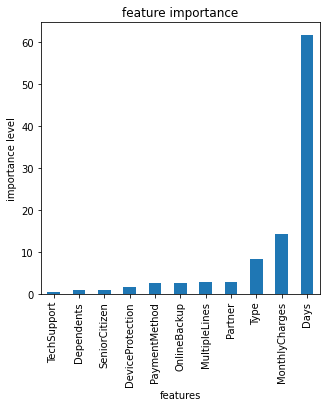

In [ ]:
imp.groupby('feature_names')['feature_importance'].sum().sort_values().plot(kind = 'bar', xlabel = 'features',ylabel = 'importance level', title = 'feature importance')
plt.show()